# 데이터 소개

- 총 11개의 데이터가 있었고, 저희는 아래 데이터를 이용했습니다.
  - case, time, timegender, timeprovince, timeage, region, searchtrend

In [76]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.pyplot as plts

import seaborn as sns
import seaborn as sns; sns.set()

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

import chart_studio.plotly as py
import cufflinks as cf
import plotly.graph_objects as go
cf.go_offline(connected=True)
%matplotlib inline

In [186]:
from matplotlib import rc
import matplotlib.font_manager as fm

# 디렉토리 및 파일 이름에 맞추어 변경
font_location = './NanumGothic.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

## 데이터 로드 및 전처리

- 사용하는 각 파일의 date를 datetime으로 전처리해주기

In [187]:
case = pd.read_csv("./covid/Case.csv")
time = pd.read_csv("./covid/Time.csv")
tg = pd.read_csv('./covid/timegender.csv')
tp = pd.read_csv('./covid/TimeProvince.csv')
ta = pd.read_csv('./covid/TimeAge.csv')
st = pd.read_csv("./covid/SearchTrend.csv")
region  = pd.read_csv("./covid/Region.csv")

time['date'] = pd.to_datetime(time['date'])
tg['date'] = pd.to_datetime(tg['date'])
tp['date'] = pd.to_datetime(tp['date'])
ta['date'] = pd.to_datetime(ta['date'])
st['date'] = pd.to_datetime(st['date'])

## Time Province
- 광역시, 특별시, 도 별 누적 확진자를 일일 확진자를 구함.
- 휴일과 확진자의 관계를 살펴봄

In [188]:
tp = tp.sort_values(by=['province', 'date'], ascending=True)
tp

,date,time,province,confirmed,released,deceased
1,2020-01-20,16,Busan,0,0,0
18,2020-01-21,16,Busan,0,0,0
35,2020-01-22,16,Busan,0,0,0
52,2020-01-23,16,Busan,0,0,0
69,2020-01-24,16,Busan,0,0,0
...,...,...,...,...,...,...
2692,2020-06-26,0,Ulsan,55,49,1
2709,2020-06-27,0,Ulsan,55,50,1
2726,2020-06-28,0,Ulsan,55,50,1
2743,2020-06-29,0,Ulsan,55,50,1


### 휴일 설정

In [189]:
# 2020년 공휴일 (1월20일~6월30일)
holiday = ['2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27','2020-03-01', '2020-04-15', '2020-04-30', '2020-05-05', '2020-06-06']

In [190]:
tp['holiday'] = tp['date'].isin(holiday)
tp

,date,time,province,confirmed,released,deceased,holiday
1,2020-01-20,16,Busan,0,0,0,False
18,2020-01-21,16,Busan,0,0,0,False
35,2020-01-22,16,Busan,0,0,0,False
52,2020-01-23,16,Busan,0,0,0,False
69,2020-01-24,16,Busan,0,0,0,True
...,...,...,...,...,...,...,...
2692,2020-06-26,0,Ulsan,55,49,1,False
2709,2020-06-27,0,Ulsan,55,50,1,False
2726,2020-06-28,0,Ulsan,55,50,1,False
2743,2020-06-29,0,Ulsan,55,50,1,False


In [191]:
tp['province'].unique()

array(['Busan', 'Chungcheongbuk-do', 'Chungcheongnam-do', 'Daegu',
       'Daejeon', 'Gangwon-do', 'Gwangju', 'Gyeonggi-do',
       'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Incheon', 'Jeju-do',
       'Jeollabuk-do', 'Jeollanam-do', 'Sejong', 'Seoul', 'Ulsan'],
      dtype=object)

### 일일 확진자 구하기

In [192]:
confirmed_li = []
for p in tp['province'].unique():
    c = tp[tp['province']==p]['confirmed'].diff()
    
    confirmed_li.append(c)
    
tp['daily_confirmed'] = pd.concat(confirmed_li)

In [193]:
tp

,date,time,province,confirmed,released,deceased,holiday,daily_confirmed
1,2020-01-20,16,Busan,0,0,0,False,NaN
18,2020-01-21,16,Busan,0,0,0,False,0.0
35,2020-01-22,16,Busan,0,0,0,False,0.0
52,2020-01-23,16,Busan,0,0,0,False,0.0
69,2020-01-24,16,Busan,0,0,0,True,0.0
...,...,...,...,...,...,...,...,...
2692,2020-06-26,0,Ulsan,55,49,1,False,0.0
2709,2020-06-27,0,Ulsan,55,50,1,False,0.0
2726,2020-06-28,0,Ulsan,55,50,1,False,0.0
2743,2020-06-29,0,Ulsan,55,50,1,False,0.0


## 지역별 누적 확진자 추세
- 휴일 이후로 누적 그래프의 경사가 급격하게 변하는 경향이 있다.

In [194]:
fig = go.Figure()

for p in tp['province'].unique():
    tp_ = tp[tp['province']==p]
    fig.add_trace(
        go.Scatter(
            x=tp_['date'], y=tp_['confirmed'], name=p
        )
    )

for h in holiday: 
    fig.add_vline(x=h, line_dash="dash", line_color="green")
fig.update_layout({'title': {'text': '지역별 누적 확진자 추세'}})

fig.show()

## 지역별 일일 확진자 추세

In [195]:
fig = go.Figure()

for p in tp['province'].unique():
    tp_ = tp[tp['province']==p]
    fig.add_trace(
        go.Scatter(
            x=tp_['date'], y=tp_['daily_confirmed'], name=p
        )
    )
    
for h in holiday: 
    fig.add_vline(x=h, line_dash="dash", line_color="green")
    
fig.update_layout({'title': {'text': '지역별 일일 확진자 추세'}})

fig.show()

## 경기도에서 휴일 이후로 증가 하는 경향이 있었다.

In [75]:
    fig = go.Figure()
    tp_ = tp[tp['province']=='Gyeonggi-do']
    fig.add_trace(
        go.Scatter(
            x=tp_['date'], y=tp_['daily_confirmed'], name="Gyeonggi-do"
        )
    )
    fig.add_trace(
        go.Scatter(
            x=tp_[tp_['holiday']==True]['date'], y=tp_[tp_['holiday']==True]['daily_confirmed'], mode='markers', name='holiday'
        )
    )
    fig.update_layout({'title': {'text': f'Gyeonggi-do 일일 확진자 추세'}})
    
    fig.show()

## 나이대 따른 확진자

In [159]:
ta_cp = ta.copy()

### 월별로 나누기

In [161]:
ta_cp['year'] = ta_cp['date'].dt.year #연도
ta_cp['month'] = ta_cp['date'].dt.month #월
ta_cp['day'] = ta_cp['date'].dt.day #일

### 일일 확진자 컬럼 추가

In [163]:
daliy_list = []
for key in ta_cp['age'].unique():
    diff_num = ta_cp[ta_cp['age'] == key]['confirmed'].diff()
    
    daliy_list.append(diff_num)
    
ta_cp['daily_confirmed'] = pd.concat(daliy_list)

In [166]:
ta_cp = ta_cp.fillna(0)

In [169]:
ta_cp.head(20)

,date,time,age,confirmed,deceased,year,month,day,daily_confirmed
0,2020-03-02,0,0s,32,0,2020,3,2,0.0
1,2020-03-02,0,10s,169,0,2020,3,2,0.0
2,2020-03-02,0,20s,1235,0,2020,3,2,0.0
3,2020-03-02,0,30s,506,1,2020,3,2,0.0
4,2020-03-02,0,40s,633,1,2020,3,2,0.0
5,2020-03-02,0,50s,834,5,2020,3,2,0.0
6,2020-03-02,0,60s,530,6,2020,3,2,0.0
7,2020-03-02,0,70s,192,6,2020,3,2,0.0
8,2020-03-02,0,80s,81,3,2020,3,2,0.0
9,2020-03-03,0,0s,34,0,2020,3,3,2.0


(0.0, 50.0)

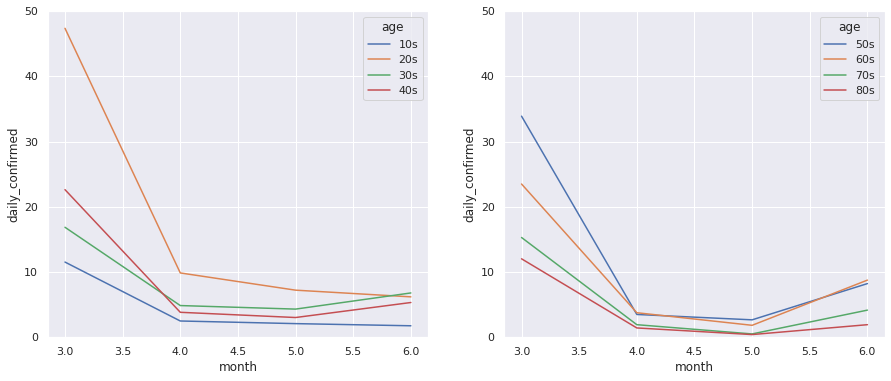

In [167]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15,6))

sns.lineplot(x="month", y="daily_confirmed", hue="age", ax = axes[0], ci=None,
             data=ta_cp[(ta_cp['age'] == '10s') | (ta_cp['age'] == '20s') | (ta_cp['age'] == '30s') | (ta_cp['age'] == '40s')])
axes[0].set_ylim(0,50)

sns.lineplot(x="month", y="daily_confirmed", hue="age", ax = axes[1], ci=None,
             data=ta_cp[(ta_cp['age'] == '50s') | (ta_cp['age'] == '60s') | (ta_cp['age'] == '70s') | (ta_cp['age'] == '80s')])
axes[1].set_ylim(0,50)

## 대구 신천지 2월 -> 많은 감염자수

### 10대 20대는 지속적으로 줄어들고, 30대 이상은 6월에 다시 증가하는 추세가 있다.

- 위의 그래프를 보면, 10s 20s는 계속 줄어들지만, 30s 이상은 6월에 다시 올라가는 성향이 보인다
 -> 왜그럴까? : 6월에 무슨 일이 있었을까?

## Search Trend
- 4가지(cold, flu, pneumonia, corona virus) 검색어 빈도수 비교
- 2016 ~ 2020년의 데이터가 존재했고, 코로나 이후 (2020.01) 이후 데이터를 사용
- 요일별로 언제 가장 많이 검색이 되는지 확인 했음.
- 일일 확진자가증가하는 날과, 코로나 바이러스 검색량 비교 해봄.

- 요일 추가

In [171]:
st['weekday'] = st['date'].dt.day_name()

- 20.01.01 이후 데이터 보관  
  이는 매년 감기, 폐렴, 독감에 대한 검색패턴을 관찰하기 위함임

In [173]:
st20 = st[st['date'].dt.year == 2020]
st20.reset_index(inplace = True, drop = True)
st20

,date,cold,flu,pneumonia,coronavirus,weekday
0,2020-01-01,0.14454,0.48434,0.44880,0.01699,Wednesday
1,2020-01-02,0.19508,0.85751,0.36471,0.01827,Thursday
2,2020-01-03,0.19581,0.80443,0.46598,0.02845,Friday
3,2020-01-04,0.60343,0.86961,0.49571,0.02136,Saturday
4,2020-01-05,0.20081,0.84152,0.41644,0.01927,Sunday
...,...,...,...,...,...,...
176,2020-06-25,0.12072,0.04190,0.11936,2.16993,Thursday
177,2020-06-26,0.11381,0.03027,0.11317,2.15139,Friday
178,2020-06-27,0.10554,0.02136,0.08354,1.96848,Saturday
179,2020-06-28,0.12563,0.02872,0.08072,2.19720,Sunday


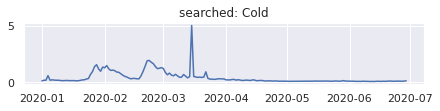

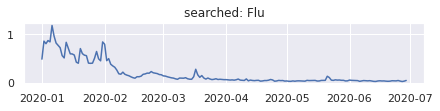

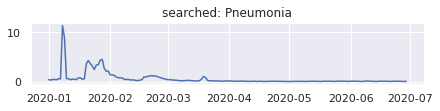

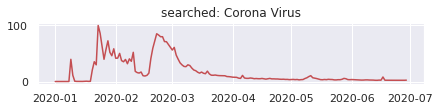

In [174]:
plt.subplots(constrained_layout=True)
plt.subplot(411)
plt.title("searched: Cold")
plt.plot(st20['date'], st20['cold'])

plt.subplots(constrained_layout=True)
plt.subplot(412)
plt.title("searched: Flu")
plt.plot(st20['date'], st20['flu'])


plt.subplots(constrained_layout=True)
plt.subplot(413)
plt.title("searched: Pneumonia")
plt.plot(st20['date'], st20['pneumonia'])

plt.subplots(constrained_layout=True)
plt.subplot(414)
plt.title("searched: Corona Virus")
plt.plot(st20['date'], st20['coronavirus'], 'r-')

In [175]:
st19 = st[st['date'].dt.year != 2020]
st19.reset_index(inplace = True, drop = True)
st19

,date,cold,flu,pneumonia,coronavirus,weekday
0,2016-01-01,0.11663,0.05590,0.15726,0.00736,Friday
1,2016-01-02,0.13372,0.17135,0.20826,0.00890,Saturday
2,2016-01-03,0.14917,0.22317,0.19326,0.00845,Sunday
3,2016-01-04,0.17463,0.18626,0.29008,0.01145,Monday
4,2016-01-05,0.17226,0.15072,0.24562,0.01381,Tuesday
...,...,...,...,...,...,...
1456,2019-12-27,0.18044,0.77006,0.26662,0.02363,Friday
1457,2019-12-28,0.16663,0.62289,0.22535,0.01609,Saturday
1458,2019-12-29,0.15826,0.57089,0.21626,0.01181,Sunday
1459,2019-12-30,0.18126,0.88570,0.31562,0.02054,Monday


- 감기는 불규칙한 분초를 보이나, 추가적인 시계열 분석이 필요
- 독감은 매년 1월에 주기적으로 검색량이 증가하나, 2017년 1월은 이례적으로 높았음
- 폐렴은 다소 규칙성이 보이는 듯 하나, 이 또한 시계열 분석이 필요

<AxesSubplot:xlabel='weekday', ylabel='coronavirus'>

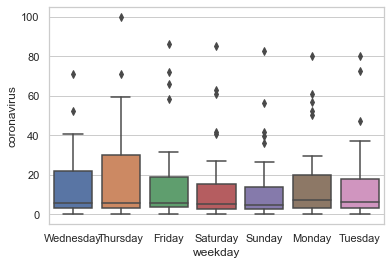

In [176]:
sns.set_style('whitegrid')
sns.boxplot(x = st20['weekday'], y = st20['coronavirus'])

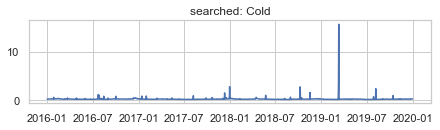

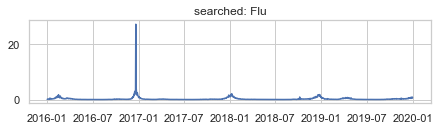

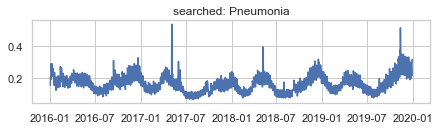

In [177]:
plt.subplots(constrained_layout=True)
plt.subplot(311)
plt.title("searched: Cold")
plt.plot(st19['date'], st19['cold'])

plt.subplots(constrained_layout=True)
plt.subplot(312)
plt.title("searched: Flu")
plt.plot(st19['date'], st19['flu'])


plt.subplots(constrained_layout=True)
plt.subplot(313)
plt.title("searched: Pneumonia")
plt.plot(st19['date'], st19['pneumonia'])

## Region

In [179]:
region_prov = region[region['province'] == region['city']]
region_prov = region_prov[region_prov.province != 'Korea']
region_prov.reset_index(inplace = True, drop = True)
region_prov

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,11000,Busan,Busan,35.179884,129.074796,304,408,22,1.40,18.41,8.6,6752
2,12000,Daegu,Daegu,35.872150,128.601783,229,355,11,1.62,15.78,7.5,5083
3,13000,Gwangju,Gwangju,35.160467,126.851392,155,312,17,2.38,13.57,6.4,2852
4,14000,Incheon,Incheon,37.456188,126.705920,250,403,7,1.27,13.20,5.8,4497
5,15000,Daejeon,Daejeon,36.350621,127.384744,148,260,15,1.49,13.65,5.8,2984
6,16000,Ulsan,Ulsan,35.539797,129.311538,119,200,4,2.21,11.76,5.2,1801
7,17000,Sejong,Sejong,36.480132,127.289021,48,60,3,1.78,9.48,3.8,491
8,20000,Gyeonggi-do,Gyeonggi-do,37.275119,127.009466,1277,2237,61,1.60,12.63,5.2,20491
9,30000,Gangwon-do,Gangwon-do,37.885369,127.729868,349,368,18,1.42,19.89,9.8,2519


In [180]:
region_city = region[region['province'] != region['city']]
region_city.reset_index(inplace = True, drop = True)
region_city

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
1,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
2,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
3,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
4,10050,Seoul,Gwanak-gu,37.478290,126.951502,22,33,1,0.89,15.12,4.9,909
...,...,...,...,...,...,...,...,...,...,...,...,...
221,61140,Gyeongsangnam-do,Tongyeong-si,34.854426,128.433210,20,29,0,1.70,18.47,9.8,230
222,61150,Gyeongsangnam-do,Hadong-gun,35.067224,127.751271,16,15,0,0.84,32.89,19.1,94
223,61160,Gyeongsangnam-do,Haman-gun,35.272481,128.406540,16,20,0,1.19,23.74,14.7,94
224,61170,Gyeongsangnam-do,Hamyang-gun,35.520541,127.725177,13,12,0,1.01,32.65,20.9,83


- 광역시/도 고령 인구 비율

C:\Users\lts27\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



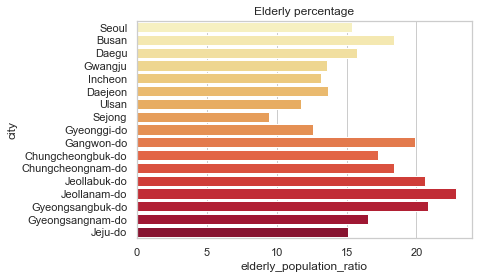

In [181]:
x = region_prov['city']
y = region_prov['elderly_population_ratio']
plt.title('Elderly percentage')

sns.barplot(y, x, alpha = 1, palette = 'YlOrRd')
plt.show()

In [182]:
time['daily confirmed'] = time['confirmed'].diff().fillna(time['confirmed'])
time

,date,time,test,negative,confirmed,released,deceased,daily confirmed
0,2020-01-20,16,1,0,1,0,0,1.0
1,2020-01-21,16,1,0,1,0,0,0.0
2,2020-01-22,16,4,3,1,0,0,0.0
3,2020-01-23,16,22,21,1,0,0,0.0
4,2020-01-24,16,27,25,2,0,0,1.0
...,...,...,...,...,...,...,...,...
158,2020-06-26,0,1232315,1200885,12602,11172,282,39.0
159,2020-06-27,0,1243780,1211261,12653,11317,282,51.0
160,2020-06-28,0,1251695,1219975,12715,11364,282,62.0
161,2020-06-29,0,1259954,1228698,12757,11429,282,42.0


## 일일 확진자-코로나 바이러스 검색량 비교

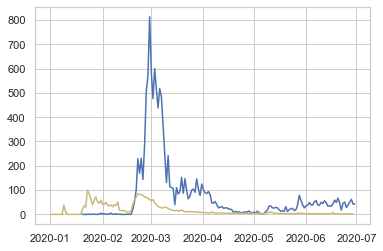

In [183]:
plt.plot(time['date'], time['daily confirmed'], color = 'b')
plt.plot(st20['date'], st20['coronavirus'], color = 'y')
plt.show()

## Case, Region

- 행정구역 제거

- train : case

In [90]:
region_cp = region.copy()

In [107]:
pro_region_cp = region_cp.drop_duplicates(["province"]) # p1
city_region_cp = region_cp.drop_duplicates(["city"]) # cityp

In [94]:
clat = city_region_cp.latitude
clon = city_region_cp.longitude
clat = pd.to_numeric(clat,errors='coerce')
clon = pd.to_numeric(clon,errors='coerce')

In [108]:
pv = pro_region_cp.province
pla = pro_region_cp.latitude
plo = pro_region_cp.longitude

In [110]:
nurse = pro_region_cp.nursing_home_count
elderly = pro_region_cp.elderly_population_ratio
eldratio = pro_region_cp.elderly_alone_ratio

In [113]:
edif = elderly-eldratio

In [125]:
pv1 = pd.to_numeric(pv,errors='coerce')
t2 = pd.to_numeric(case.latitude,errors='coerce')
t3 = pd.to_numeric(case.longitude,errors='coerce')

## 대학교가 몰려 있는 서울과 부산에서 확진자의 수가 집중된걸 확인 할 수가 있다.

(125.0, 131.0)

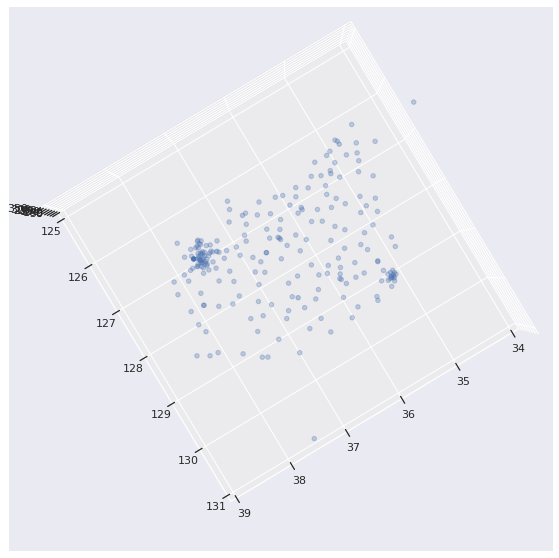

In [136]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(clat, clon, city_region_cp.university_count)
ax1.view_init(90, 55)
plt.xlim([34, 39]) 
plt.ylim([125, 131])